# P3.Advance Lane Finding

### Goals of the project

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
%pylab inline 
import os
import cv2
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [15]:
pylab.rcParams['figure.figsize'] = (18, 12)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_images(images, row=1, im_prep=None, titles=None, cmap=None):
    add_col = 1 if (len(images) % row) else 0
    col = (len(images) // row) + add_col
    fig, axes = subplots(row,col, subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    if im_prep is None:
        im_prep = lambda x: x

    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = im_prep(images[i])
        if (len(img.shape) < 3) and cmap is None:
            cmap='gray'
        ax.imshow(img, cmap=cmap)
        if titles is not None:
            ax.set_title(titles[i])
    show()

## 1. Camera calibration

### 1.1. Load the calibration images

In [3]:
camera_cal = 'camera_cal/'
chessboard_images = []
for filename in os.listdir(camera_cal):
    image = cv2.imread(camera_cal + filename)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        chessboard_images.append(image)
print(len(chessboard_images))

20


In [4]:
print(imread(camera_cal+filename).shape)

(720, 1280, 3)


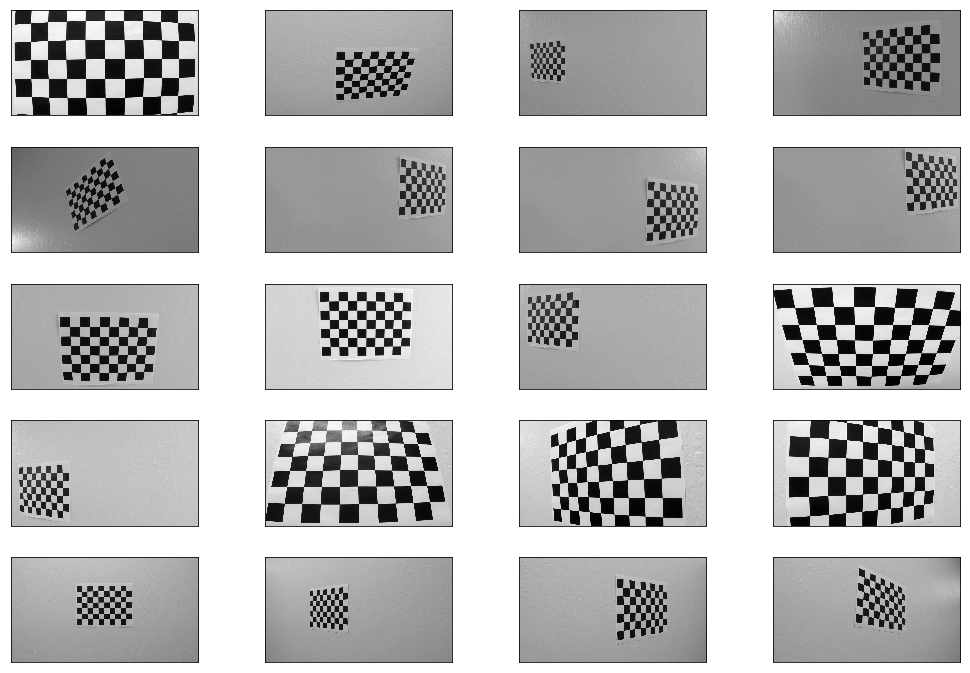

In [5]:
plot_images(chessboard_images, row=5)

### 1.2. Find chessboard corners with opencv

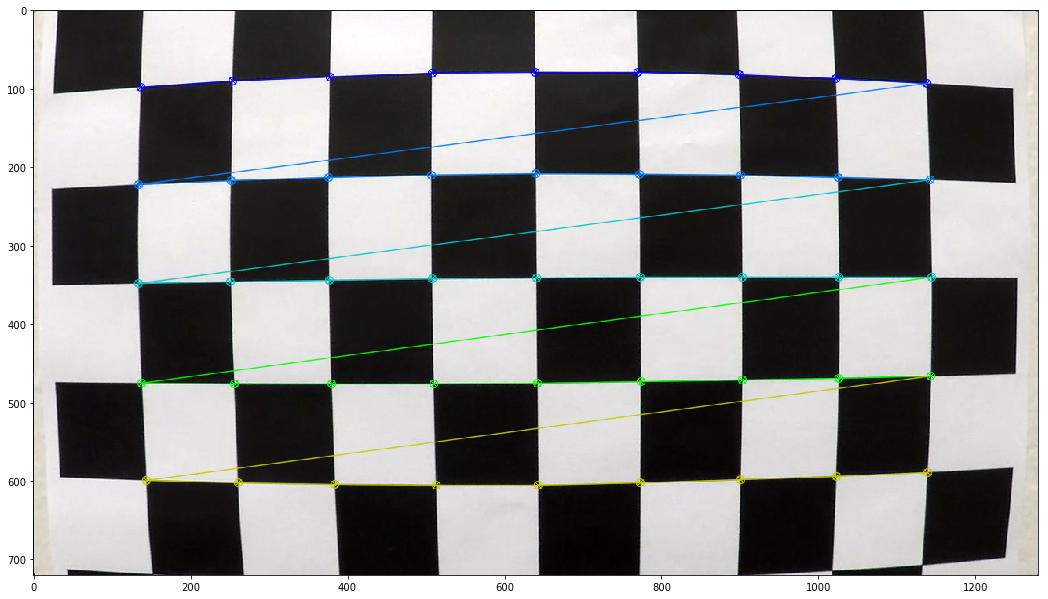

In [6]:
chessboard_image = imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(chessboard_image, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 5), None)
# If found, draw corners
if ret == True:
    img = cv2.drawChessboardCorners(chessboard_image, (9,5), corners, ret)
    imshow(img)

### 1.3. Calibrating

objectPoints –
In the new interface it is a vector of vectors of calibration pattern points in the calibration pattern coordinate space (e.g. std::vector<std::vector<cv::Vec3f>>). The outer vector contains as many elements as the number of the pattern views. If the same calibration pattern is shown in each view and it is fully visible, all the vectors will be the same. Although, it is possible to use partially occluded patterns, or even different patterns in different views. Then, the vectors will be different. The points are 3D, but since they are in a pattern coordinate system, then, if the rig is planar, it may make sense to put the model to a XY coordinate plane so that Z-coordinate of each input object point is 0.

In the old interface all the vectors of object points from different views are concatenated together.

imagePoints –
In the new interface it is a vector of vectors of the projections of calibration pattern points (e.g. std::vector<std::vector<cv::Vec2f>>). imagePoints.size() and objectPoints.size() and imagePoints[i].size() must be equal to objectPoints[i].size() for each i.

In the old interface all the vectors of object points from different views are concatenated together.


In [7]:
# number of corners nx & ny 
n_corners = (9, 6) 
nx = n_corners[0]
ny = n_corners[1]

In [8]:
# for the meth cv2.calibraceCamera we need objpoints
objpoints = []
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

In [9]:
imgpoints = []
for gray in chessboard_images:
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    # If found, add to imgpoints
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
print(len(imgpoints))

17


In [10]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

### 1.4. Correcting for distortion 

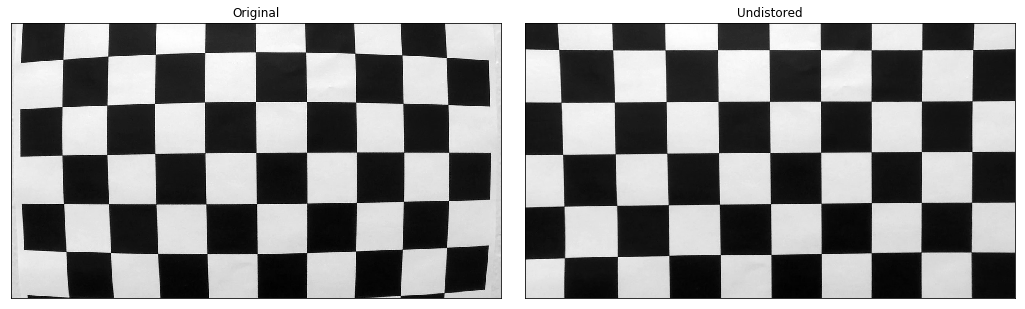

In [11]:
img = chessboard_images[0]
dst = cv2.undistort(img, mtx, dist, None, mtx)
#imshow(np.hstack((img, dst)), cmap='gray')
plot_images((img, dst), cmap='gray', im_prep=None, titles=('Original', 'Undistored'))

In [12]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

##### it's working! The right image has strate orthogonal lines
## 2. Applying a distortion correction

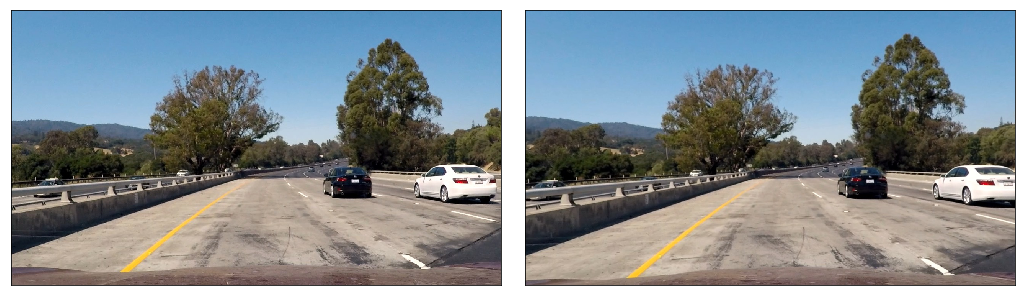

In [16]:
img = cv2.imread('test_images/test1.jpg')

plot_images((img, undistort(img)), im_prep=bgr2rgb)

## 3. Transform image

In [17]:
def corners_unwarp(img, nx, ny):
    # remove distortion
    undist = undistort(img)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def transform(undist_img, matrix):
     cv2.warpPerspective(undist_img, matrix, undist_img.shape[-2::-1])

img = cv2.imread('camera_cal/calibration12.jpg')
dst = undistort(img)
warp, matrix = corners_unwarp(img, nx, ny)

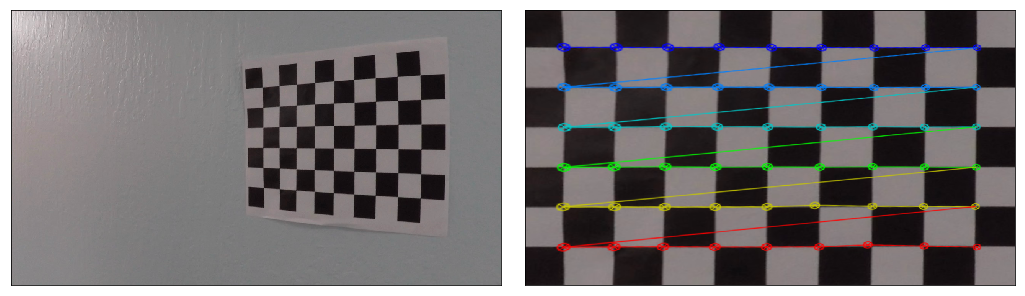

In [18]:
plot_images((img, warp))

In [292]:
corners_int = np.int32([[190,720],[584,457],[700,457],[1126,720]])
def getMatrix():
    corners = np.float32(corners_int)
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[200,0]
    
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset,corners[3]-offset])
    M = cv2.getPerspectiveTransform(src, dst) 
    return M

camera_M = getMatrix()

def warp_camera(img, inv=False):
    if len(img.shape)==3:
        img_size = img.shape[-2::-1]
    else:
        img_size = img.shape[::-1]
    flags = cv2.INTER_LINEAR + cv2.WARP_FILL_OUTLIERS
    if inv:
        flags += cv2.WARP_INVERSE_MAP
    return cv2.warpPerspective(img, camera_M, img_size, flags=flags)

(1280, 720)
(1280, 720)


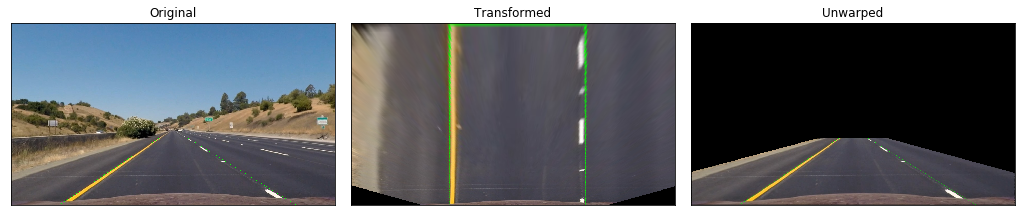

(720, 1280, 3)
(720, 1280, 3)


In [286]:
camera_img = cv2.imread('test_images/straight_lines1.jpg')
undist = undistort(camera_img)
cv2.polylines(undist, [corners_int], True, [0,255,0])
warp = warp_camera(undist)

plot_images((undist, warp, warp_camera(warp, True)), titles=('Original', 'Transformed', 'Unwarped'), im_prep=brg2rgb)
print(camera_img.shape)
print(warp.shape)

In [287]:
def transform(img, inv=False):
    """
    returns undistorted and warped img
    """
    undist = undistort(img)
    
    warp = warp_camera(undist, inv)
    return warp

(1280, 720)


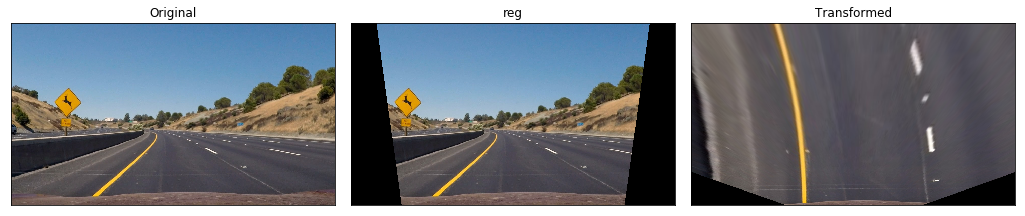

(720, 1280, 3)


In [230]:
camera_img = cv2.imread('test_images/test2.jpg')
reg_img = region_of_interest(camera_img)
plot_images((camera_img, reg_img, transform(reg_img)), titles=('Original','reg', 'Transformed'), im_prep=bgr2rgb)
print(camera_img.shape)

In [238]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    h,w = img.shape[:2]
    reg_bl = [220, h]          
    reg_br = [w-220, h]          
    reg_tl = [100, 0]
    reg_tr = [w-100, 0]
    vertices = np.array([[reg_bl, reg_tl, reg_tr, reg_br]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

(1280, 720)


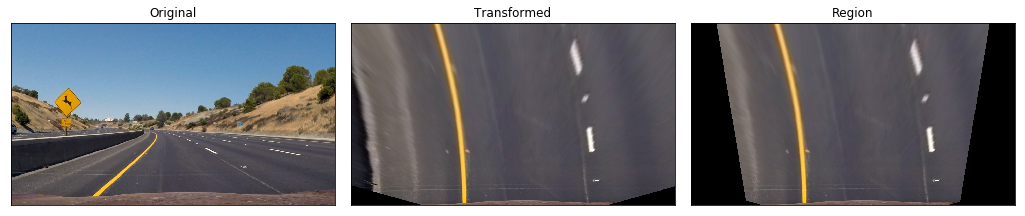

(720, 1280, 3)


In [239]:
camera_img = cv2.imread('test_images/test2.jpg')
transf = transform(camera_img)
plot_images((camera_img, transf, region_of_interest(transf)), titles=('Original','Transformed', 'Region'), im_prep=bgr2rgb)
print(camera_img.shape)

## 4. Thresholded binary image

(1280, 720)


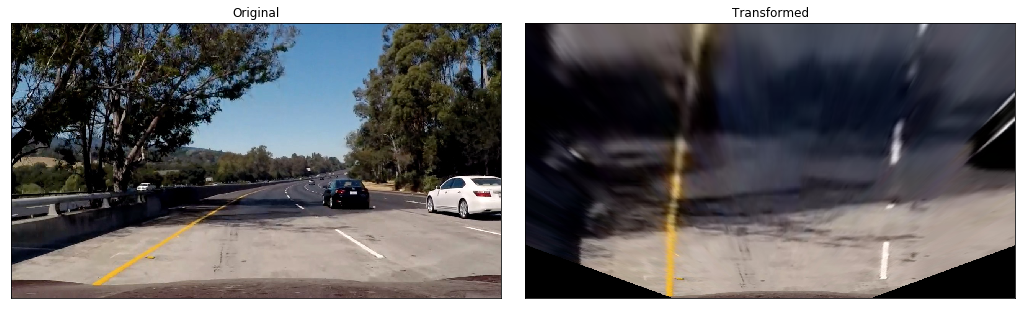

(720, 1280, 3)


In [257]:
img = cv2.imread('test_images/test5.jpg')
transf = transform(region_of_interest(img))

plot_images((img, transf), titles=('Original', 'Transformed'), im_prep=bgr2rgb)
print(camera_img.shape)

In [258]:
import image_preproc as prep

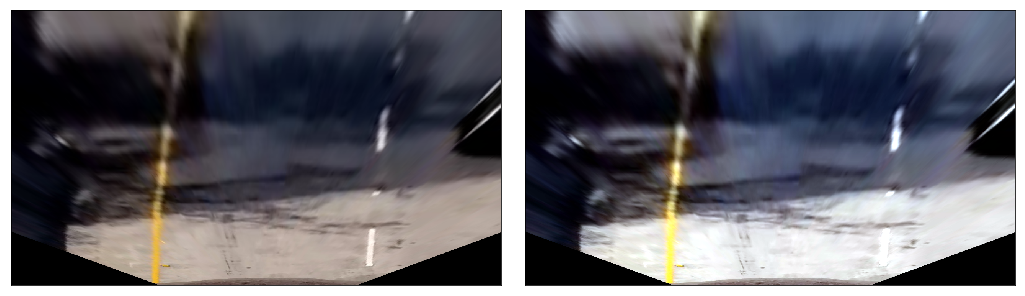

In [259]:
plot_images((transf, prep.imadjust(transf)), im_prep=bgr2rgb)

In [260]:
#prep_transf = prep.imadjust(transf)
prep_transf = transf

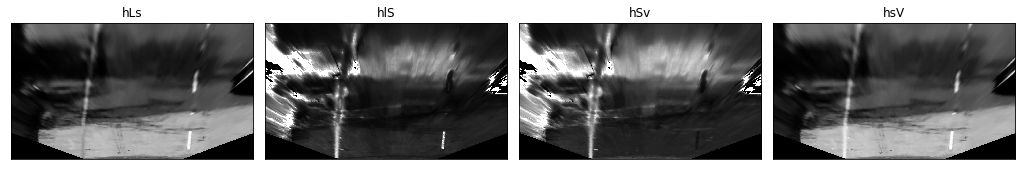

In [261]:
hls = cv2.cvtColor(prep_transf, cv2.COLOR_BGR2HLS)
hsv = cv2.cvtColor(prep_transf, cv2.COLOR_BGR2HSV)

plot_images((hls[:,:,1], hls[:,:,2], hsv[:,:,1], hsv[:,:,2]),
           titles=('hLs', 'hlS', 'hSv', 'hsV'))

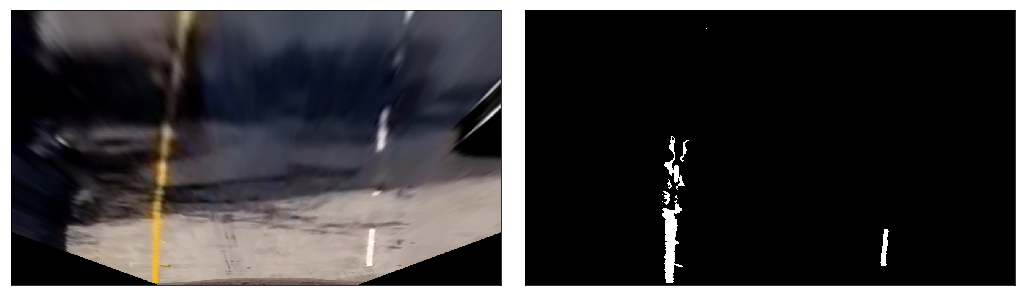

In [262]:
def ls_threshold(img, l_thresh_min=40, s_thresh_min=100):
    hls = cv2.cvtColor(transf, cv2.COLOR_BGR2HLS)
    l = hls[:,:,1]
    s = hls[:,:,2]
#     l_bin = np.zeros_like(l, dtype=np.ubyte)
#     l_bin[l>l_thresh_min] = 255
#     s_bin = np.zeros_like(s, dtype=np.ubyte)
#     s_bin[s>s_thresh_min] = 255
    ret = np.zeros_like(s, dtype=np.ubyte)
    ret[(l>l_thresh_min) & (s>s_thresh_min)] = 255
    return ret
plot_images((bgr2rgb(prep_transf), ls_threshold(prep_transf)))

In [263]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # sobel threshold
    dx = 1 if orient == 'x' else 0
    dy = 1 if orient != 'x' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_thresheld(image, sobel_kernel=3, mag_thresh=(20, 100)):
    # Convert to grayscale
    gray = image
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = image
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


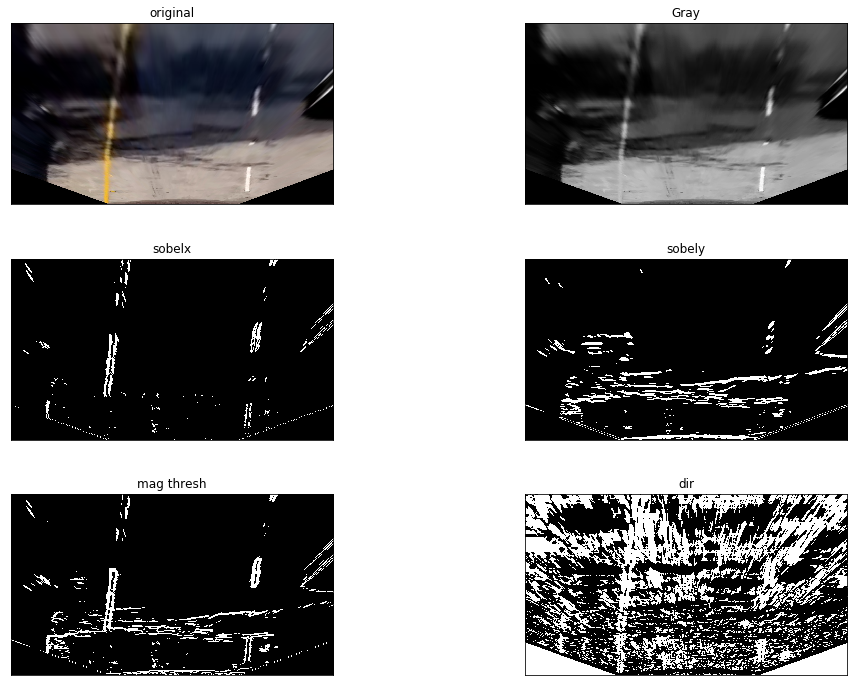

In [264]:
gray = cv2.cvtColor(prep_transf, cv2.COLOR_BGR2GRAY)
gradx  = abs_sobel_threshold(gray, 'x', 5, thresh=(30, 100))
grady = abs_sobel_threshold(gray, 'y', 15, thresh=(20, 100))
mg_thresh = mag_thresheld(gray, sobel_kernel=5, mag_thresh=(15, 70))
dir_thresh = dir_threshold(gray, sobel_kernel=15, thresh=(-0.1, .8))
plot_images((bgr2rgb(transf), gray, gradx, grady, mg_thresh, dir_thresh), row=3,
            titles=('original','Gray', 'sobelx', 'sobely', 'mag thresh', 'dir'))

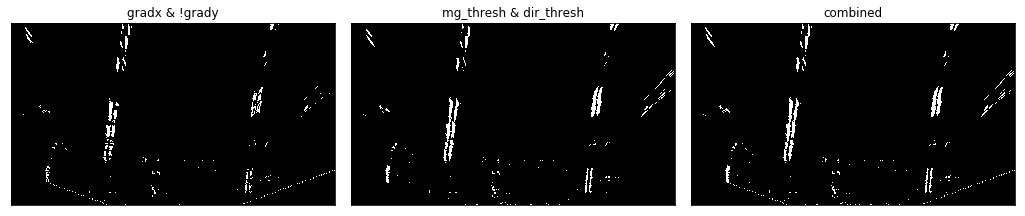

In [265]:
gradxy = np.zeros_like(dir_thresh)
gradxy[((gradx == 1) & (grady != 1)) ] = 255

dir_mag = np.zeros_like(dir_thresh)
dir_mag[((mg_thresh == 1) & (dir_thresh == 1))] = 255

combined = np.zeros_like(dir_thresh)
combined[((gradx == 1) & (grady != 1)) | ((mg_thresh == 1) & (dir_thresh == 1))] = 255

plot_images((gradxy, dir_mag, combined), titles=('gradx & !grady', 'mg_thresh & dir_thresh', 'combined'))

In [266]:
ls_thresh = ls_threshold(prep_transf)

In [267]:
binary = np.zeros_like(ls_thresh)
binary[(ls_thresh==255) | (combined==255)] = 255
binary = region_of_interest(binary)

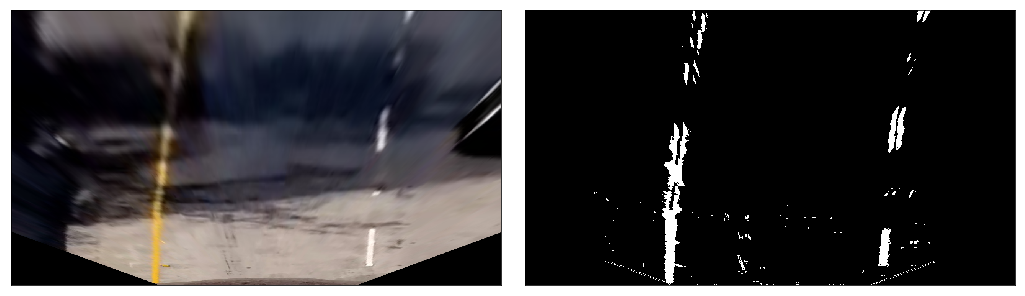

In [268]:
plot_images((bgr2rgb(transf),binary))

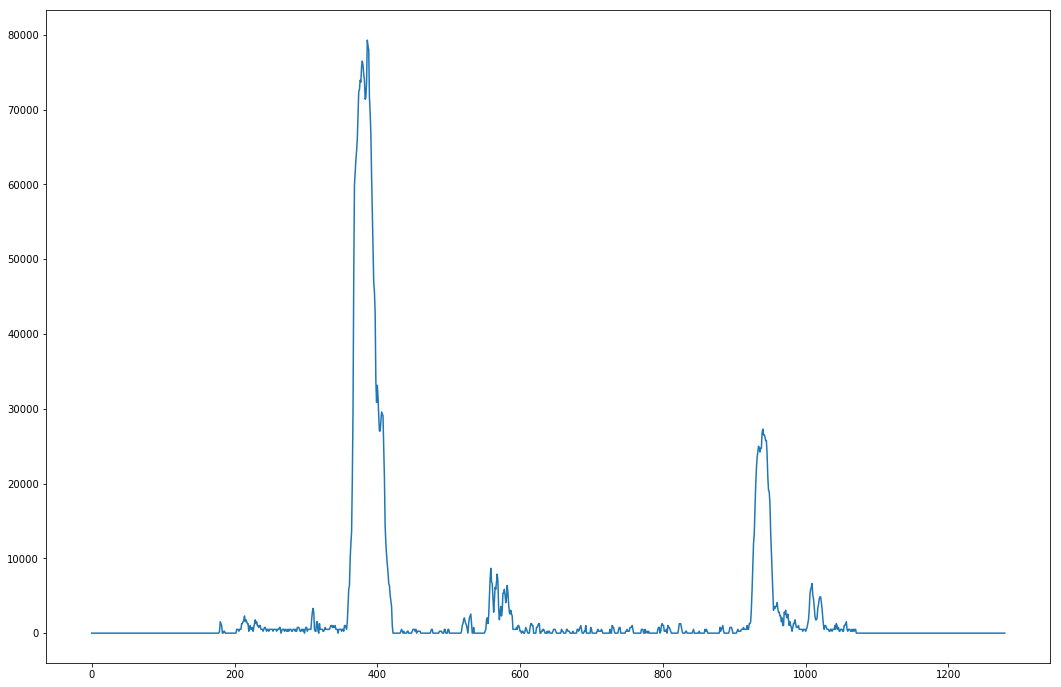

In [269]:
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plot(histogram)

In [271]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = binary
halfw = binary_warped.shape[0]//2
histogram = np.sum(binary_warped[halfwploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

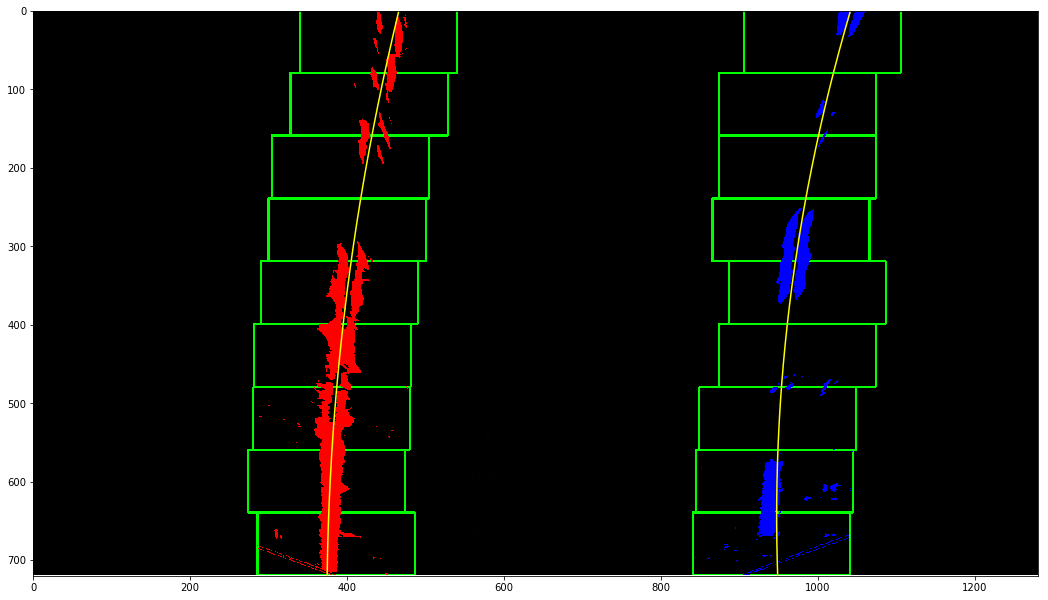

In [272]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
imshow(out_img)
plot(left_fitx, ploty, color='yellow')
plot(right_fitx, ploty, color='yellow')
xlim(0, 1280)
ylim(720, 0)

(720, 0)

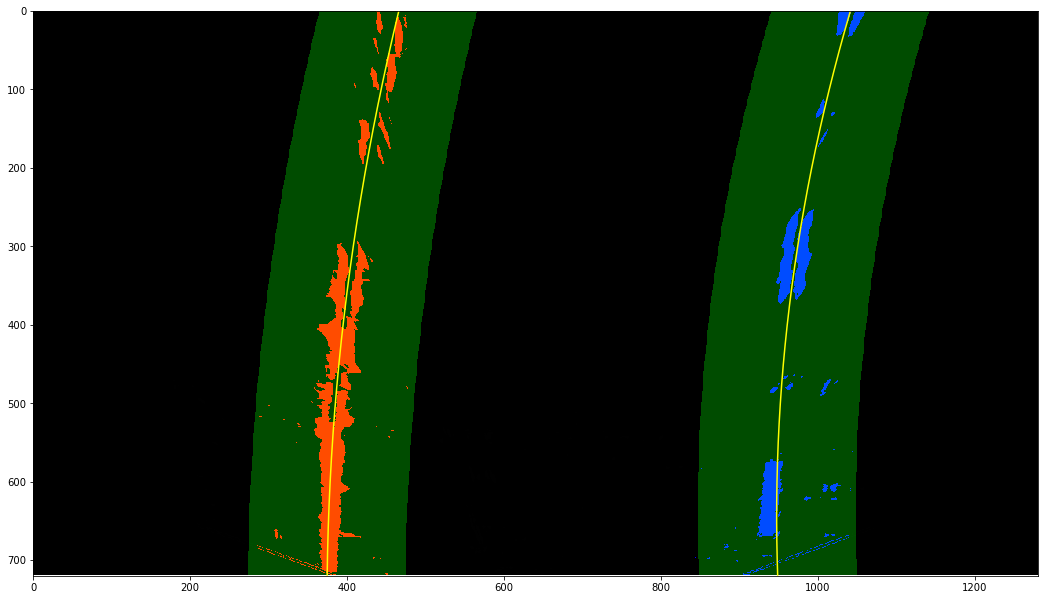

In [273]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
imshow(result)
plot(left_fitx, ploty, color='yellow')
plot(right_fitx, ploty, color='yellow')
xlim(0, 1280)
ylim(720, 0)

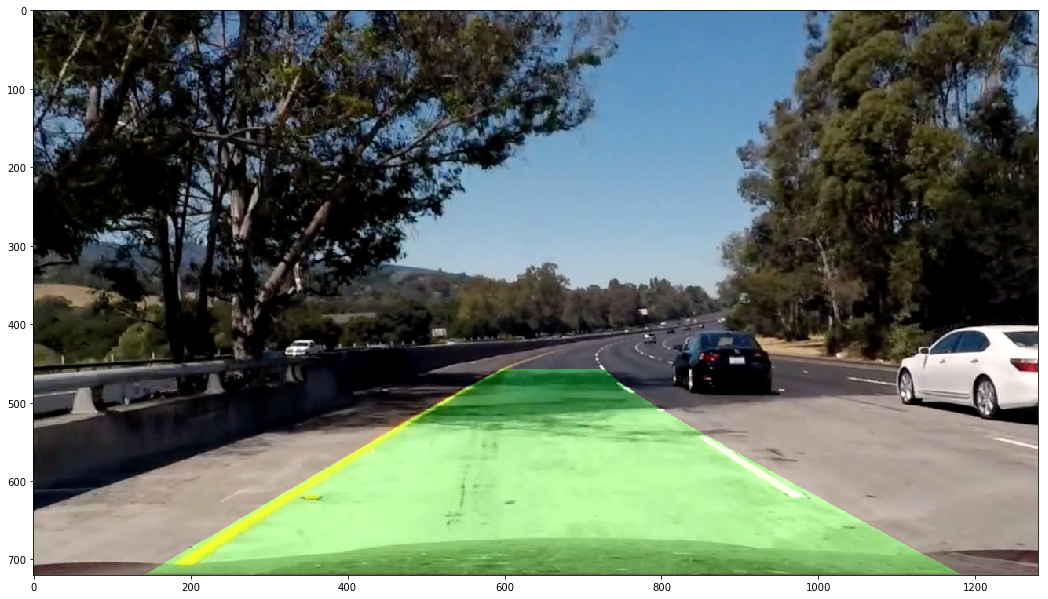

In [302]:
# Create an image to draw the lines on
warped = binary
warp_zero = np.zeros_like(warped, dtype=np.ubyte)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
undist = undistort(img)
newwarp = transform(color_warp, True)
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
imshow(bgr2rgb(result))